In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
from datetime import datetime


### 1. Datapreparation ###

In [2]:
#setting up ML-Flow for tracking the training
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('(Variational)Autoencoders/GANs')

<Experiment: artifact_location='mlflow-artifacts:/236157430189849075', creation_time=1733847234065, experiment_id='236157430189849075', last_update_time=1733847234065, lifecycle_stage='active', name='(Variational)Autoencoders/GANs', tags={}>

In [3]:
BASE_DIR = '../data/lego-minifigures'
PATH_INDEX = pd.read_csv('../data/lego-minifigures/index.csv')

In [4]:
config = {
    'test_size': 0.3,
    'img_size': 64,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'epochs': 32
}

In [5]:
#define dataset class 
class LegoDataset(Dataset):
    def __init__(self, base_dir, path_index, transforms):
        self.data_path = base_dir
        self.path_index = path_index
        self.transforms = transforms

    def __len__(self):
        return len(self.path_index)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.path_index.iloc[index, 0])
        img = Image.open(img_path)

        img = self.transforms(img)

        return img, self.path_index.iloc[index, 1]
    


In [6]:
#add data augmentation to the pictures for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.9, 1.1)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor()  
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

#train test split
train_paths, test_paths = train_test_split(PATH_INDEX, test_size=config['test_size'], random_state=42)

In [7]:
#define datasets
train_dataset = LegoDataset(BASE_DIR, train_paths.reset_index(drop=True), train_transforms)
test_dataset = LegoDataset(BASE_DIR, test_paths.reset_index(drop=True), test_transforms)

In [8]:
#define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle=False)

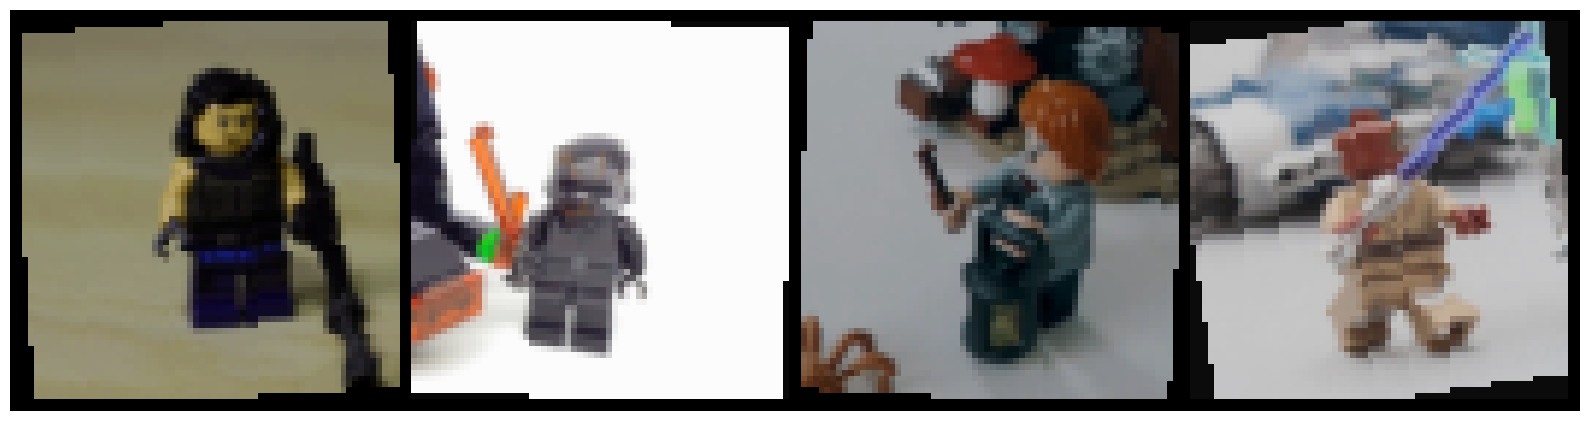

In [9]:
#show some instances of the training data
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:4])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis('off')
plt.tight_layout()
plt.show()

### 2. Autoencoders ###

In [10]:
#define the autoencoder model class
class AutoEncoder(nn.Module):
    def __init__(self, grey_scale = False):
        super().__init__()

        input_channels = 3

        if grey_scale:
            input_channels = 1

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, stride=(1, 1), kernel_size=(3, 3), padding=1), 
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.Flatten(),
            nn.Linear(4096, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 4096),
            nn.Unflatten(1, (64, 8 , 8)),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5,5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, input_channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:
#define model
autoencoder_model = AutoEncoder()

In [12]:
#train the autoencoder model
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr = config['learning_rate'])
criterion = nn.MSELoss()
train_loss = []
val_loss = []

#get name and time for run name
current_time = datetime.now().strftime("%H:%M:%S")
run_name = f"{autoencoder_model.__class__.__name__}_{current_time}"

with mlflow.start_run(run_name=run_name) as run:

    mlflow.log_param('learning_rate', config['learning_rate'])
    mlflow.log_param('batch_size', config['batch_size'])
    mlflow.log_param('num_epochs', config['epochs'])

    #iterate over epochs
    for epoch in range(config['epochs']):
        
        epoch_train_loss = []
        epoch_val_loss = []

        #training steps
        autoencoder_model.train()
        for images, _ in train_dataloader:
            reconstructed_imgs = autoencoder_model(images)

            loss = criterion(reconstructed_imgs, images)
            epoch_train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #validation steps
        autoencoder_model.eval()
        for images, _ in test_dataloader:
            with torch.no_grad():
                reconstructed_imgs = autoencoder_model(images)
                loss = criterion(reconstructed_imgs, images)
                epoch_val_loss.append(loss.item())

        #calculate epoch metrics    
        train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
        val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))

        mlflow.log_metric('train_mse', train_loss[epoch], step=epoch)
        mlflow.log_metric('val_mse', val_loss[epoch], step=epoch)

        print(f'Epoch: {epoch} Training loss: {train_loss[epoch]:.4f} | Validation loss: {val_loss[epoch]:.4f}')


Epoch: 0 Training loss: 0.0815 | Validation loss: 0.0567
Epoch: 1 Training loss: 0.0667 | Validation loss: 0.0547
Epoch: 2 Training loss: 0.0635 | Validation loss: 0.0446
Epoch: 3 Training loss: 0.0539 | Validation loss: 0.0400
Epoch: 4 Training loss: 0.0450 | Validation loss: 0.0388
Epoch: 5 Training loss: 0.0426 | Validation loss: 0.0334
Epoch: 6 Training loss: 0.0382 | Validation loss: 0.0320
Epoch: 7 Training loss: 0.0388 | Validation loss: 0.0328
Epoch: 8 Training loss: 0.0364 | Validation loss: 0.0316
Epoch: 9 Training loss: 0.0352 | Validation loss: 0.0306
Epoch: 10 Training loss: 0.0333 | Validation loss: 0.0277
Epoch: 11 Training loss: 0.0326 | Validation loss: 0.0283
Epoch: 12 Training loss: 0.0311 | Validation loss: 0.0256
Epoch: 13 Training loss: 0.0279 | Validation loss: 0.0262
Epoch: 14 Training loss: 0.0255 | Validation loss: 0.0242
Epoch: 15 Training loss: 0.0258 | Validation loss: 0.0265
Epoch: 16 Training loss: 0.0263 | Validation loss: 0.0263
Epoch: 17 Training loss:

2024/12/10 18:30:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run AutoEncoder_18:28:13 at: http://127.0.0.1:5000/#/experiments/236157430189849075/runs/703e68fa60164dc8a5484977bbbfc351.
2024/12/10 18:30:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236157430189849075.


Epoch: 31 Training loss: 0.0185 | Validation loss: 0.0176


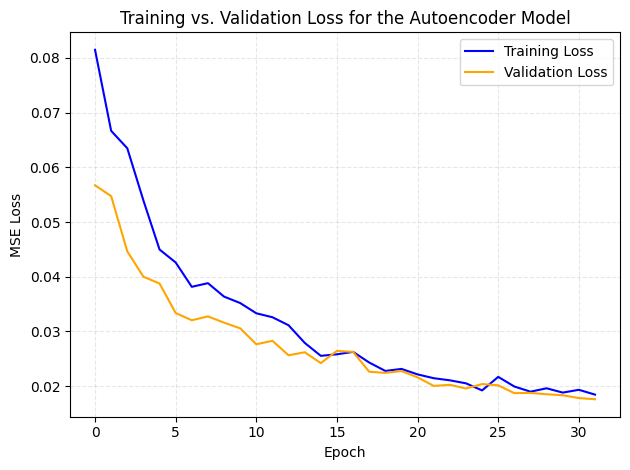

In [13]:
#plt train/val curves
with torch.no_grad():
    plt.plot(train_loss, color='blue', label='Training Loss')
    plt.plot(val_loss, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss for the Autoencoder Model')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

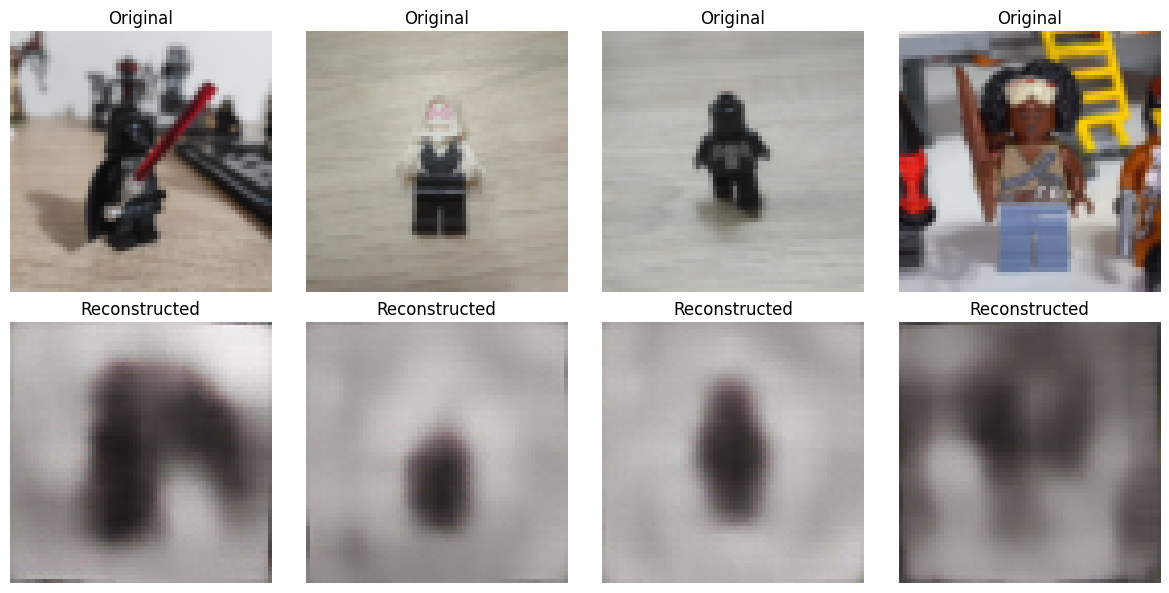

In [14]:
#test the model
test_images, labels = next(iter(test_dataloader))

test_images = test_images[:4]

# Get the reconstructed images
with torch.no_grad():
    reconstructed_imgs = autoencoder_model(test_images)

# Create a grid to compare original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 

#plot original
for i, ax in enumerate(axes[0]):
    ax.imshow(test_images[i].permute(1, 2, 0).numpy())  
    ax.set_title("Original")
    ax.axis("off")

#plot recunstructed
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_imgs[i].permute(1, 2, 0).numpy())  
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
#print hidden dim
encoder_model = autoencoder_model.encoder
with torch.no_grad():
    print(encoder_model(test_images))

tensor([[-2.1150,  0.8848,  1.0216,  4.0290, -0.4878, -1.3814, -0.5371, -2.7186,
         -1.6200, -2.1144, -0.8873,  4.1084,  1.1022, -0.5265,  0.6361,  1.5564,
          2.1231,  2.6986, -0.8212,  1.9179,  2.8258, -1.8940,  1.9646, -4.6602,
         -1.0207,  4.6999, -0.8961, -1.6428,  1.9825, -1.8549,  2.2605, -5.1258,
         -4.6673, -2.2858, -0.9343,  3.2996,  0.7638, -0.5717, -2.1408, -3.6670,
          2.7553,  0.9836,  0.6638, -0.7468,  1.3269, -0.1686,  1.4978,  3.2498,
         -0.0330, -3.3081,  0.2124,  0.9790,  2.3816, -0.0224,  2.1699,  4.7723,
         -0.9270, -1.8774,  2.2212,  3.1407,  2.6443,  4.0785, -1.7465, -1.5770,
          2.9067,  0.5125, -0.5568, -0.2593,  1.1179, -1.3805,  0.1968,  1.8598,
         -0.8564,  4.4028,  4.6320,  1.3923,  0.4035,  3.9706, -0.7402,  3.5302,
          0.1838,  0.2987,  1.6721, -2.6201,  1.9239, -2.4239,  0.0237,  1.4771,
          0.0421,  0.5311, -1.6242, -0.2958, -0.3811, -4.6110,  1.0528, -1.0200,
          3.7850,  2.7545, -

### 3. Variational Autoencoders ###

In [16]:
#define VAE model class
class VAE(nn.Module):
    def __init__(self, grey_scale = False):
        super().__init__()
        input_channels = 3

        if grey_scale:
            input_channels = 1

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, stride=(1, 1), kernel_size=(3, 3), padding=1), 
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(4096, 128)
        self.z_log_var = nn.Linear(4096, 128)
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 4096),
            nn.Unflatten(1, (64, 8 , 8)),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5,5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, input_channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Sigmoid()  
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        return encoded
    
    def reparametrize(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.size(0), z_mean.size(1))
        z = z_mean + eps * torch.exp(z_log_var/2.) 
        return z
    
    def forward(self,x):
        x=self.encoder(x)
        z_mean, z_log_var =self.z_mean(x), self.z_log_var(x)
        encoded =self.reparametrize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [17]:
#define vae loss function with KL divergence
def vae_loss(reconstructed, original, mu, logvar):
    recon_loss = F.mse_loss(reconstructed, original, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [18]:
#define the model
vae_model = VAE()

In [19]:
#train VAE model
optimizer = torch.optim.Adam(vae_model.parameters(), lr = config['learning_rate'])
criterion = nn.MSELoss()
train_loss = []
val_loss = []

current_time = datetime.now().strftime("%H:%M:%S")
run_name = f"{vae_model.__class__.__name__}_{current_time}"

with mlflow.start_run(run_name=run_name) as run:

    mlflow.log_param('learning_rate', config['learning_rate'])
    mlflow.log_param('batch_size', config['batch_size'])
    mlflow.log_param('num_epochs', config['epochs'])

    #iterate over epochse
    for epoch in range(config['epochs']):
        
        epoch_train_loss = []
        epoch_val_loss = []

        #training steps
        vae_model.train()
        for images, _ in train_dataloader:
            encoded, z_mean, z_log_var, decoded  = vae_model(images)

            loss = vae_loss(decoded, images, z_mean, z_log_var)
            epoch_train_loss.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #vaidation steps
        vae_model.eval()
        for images, _ in test_dataloader:
            with torch.no_grad():
                encoded, z_mean, z_log_var, decoded = vae_model(images)
                loss = vae_loss(decoded, images, z_mean, z_log_var)
                epoch_val_loss.append(loss)
        
        #calculate batch metrics
        with torch.no_grad():    
            train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
            val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))
        
        mlflow.log_metric('train_mse', train_loss[epoch], step=epoch)
        mlflow.log_metric('val_mse', val_loss[epoch],step=epoch)

        print(f'Epoch: {epoch} Training loss: {train_loss[epoch]:.4f} | Validation loss: {val_loss[epoch]:.4f}')

Epoch: 0 Training loss: 29019.4023 | Validation loss: 24135.8301
Epoch: 1 Training loss: 27827.5117 | Validation loss: 18788.4844
Epoch: 2 Training loss: 22498.7598 | Validation loss: 15696.1387
Epoch: 3 Training loss: 20318.1055 | Validation loss: 14631.3643
Epoch: 4 Training loss: 19198.3418 | Validation loss: 14376.1406
Epoch: 5 Training loss: 19138.2441 | Validation loss: 13775.9980
Epoch: 6 Training loss: 17817.1914 | Validation loss: 13689.0547
Epoch: 7 Training loss: 15727.8887 | Validation loss: 12569.6729
Epoch: 8 Training loss: 15915.7705 | Validation loss: 12497.6719
Epoch: 9 Training loss: 15483.5625 | Validation loss: 12762.1748
Epoch: 10 Training loss: 16369.2236 | Validation loss: 13148.5859
Epoch: 11 Training loss: 15705.0518 | Validation loss: 12483.2744
Epoch: 12 Training loss: 15621.7012 | Validation loss: 12258.5459
Epoch: 13 Training loss: 14013.5938 | Validation loss: 12602.0859
Epoch: 14 Training loss: 14606.8076 | Validation loss: 12610.7383
Epoch: 15 Training l

2024/12/10 18:33:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run VAE_18:30:35 at: http://127.0.0.1:5000/#/experiments/236157430189849075/runs/f9a79918a9a349d8863d6df19775b01c.
2024/12/10 18:33:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236157430189849075.


Epoch: 31 Training loss: 10686.8945 | Validation loss: 9603.3379


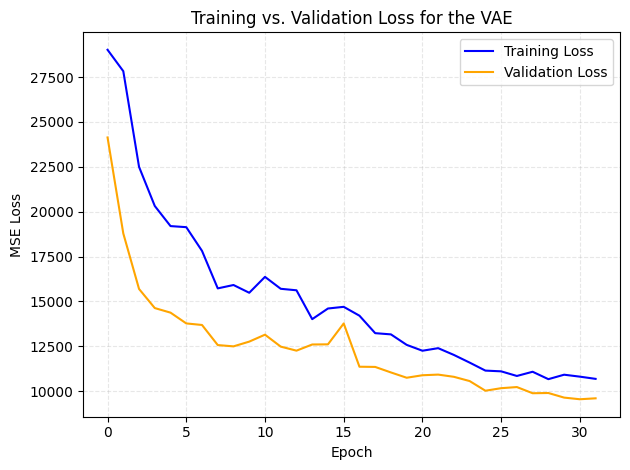

In [20]:
#plot training / validation curve
with torch.no_grad():
    plt.plot(train_loss, color='blue', label='Training Loss')
    plt.plot(val_loss, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss for the VAE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

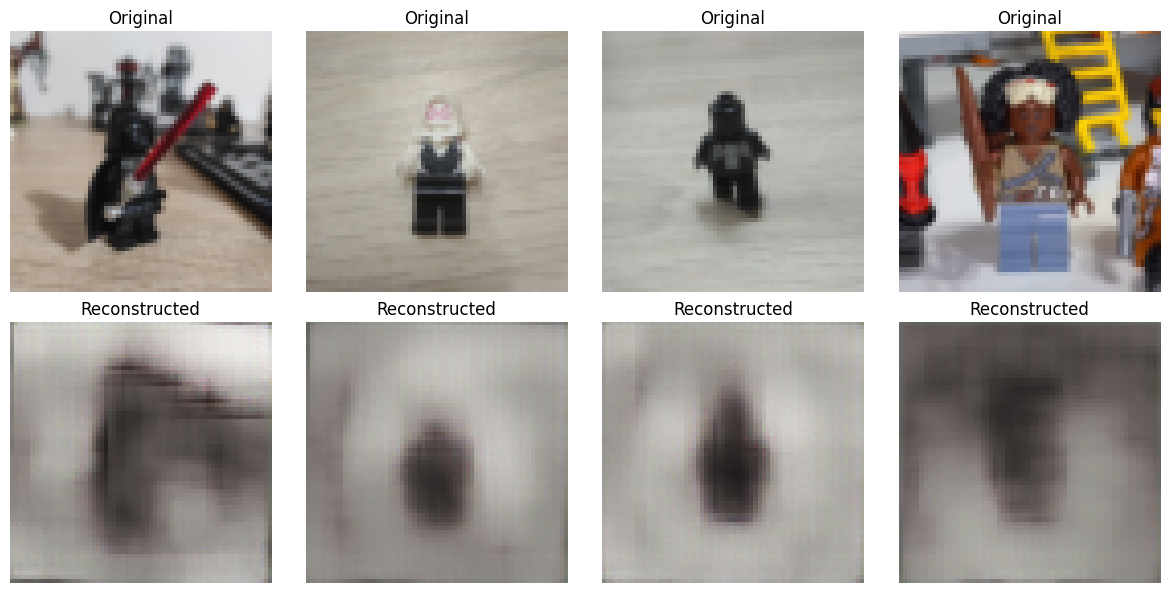

In [21]:
#reconstruct test images
with torch.no_grad():
    reconstructed_imgs = vae_model(test_images)[-1]

# Create a grid to compare original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 

#plot originals
for i, ax in enumerate(axes[0]):
    ax.imshow(test_images[i].permute(1, 2, 0).numpy())  
    ax.set_title("Original")
    ax.axis("off")

#plot recunstruced 
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_imgs[i].permute(1, 2, 0).numpy())  
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [22]:
#print hidden dim
with torch.no_grad():
    print(vae_model.encoding_fn(test_images))

tensor([[-0.2440, -0.0266,  1.8510,  1.6941,  0.4049, -1.3005,  0.2714, -1.3462,
         -0.4230,  1.1525, -0.4276,  1.9761, -0.7878,  0.4024, -0.8322, -0.6630,
         -0.7719, -1.6550, -0.9590,  0.0382,  0.0796,  0.3742, -1.4114,  0.3589,
         -1.3332, -0.7035,  0.7025,  0.1219,  1.8540,  0.7524, -0.9202,  0.7722,
          0.3885,  0.6166, -0.2794,  0.7169,  0.0361,  1.7296, -0.0029,  1.3090,
         -0.3100, -1.1826,  0.2771, -0.1100,  0.2988, -0.1837,  0.1853, -2.1784,
          0.3840, -0.8545,  2.0444,  2.0123, -0.2874,  0.2631,  0.0379, -0.8585,
         -0.3928,  0.9618, -1.0976, -0.5662, -0.7707, -0.7868,  0.2337, -1.1416,
         -0.6794,  0.2434,  0.4930,  0.5247,  1.3966,  0.1808, -0.1259,  0.8403,
         -0.7889,  0.9147, -2.0871, -0.0238,  0.4138, -0.3709,  0.4238, -0.4353,
          0.8692, -0.1897,  0.2120, -0.6512, -0.5960,  0.0722, -1.0963, -1.3103,
          0.2131,  1.2933, -2.0438, -1.3139,  0.4596, -0.0560, -0.1955, -0.3564,
         -0.4864,  0.3135,  

### 4. GAN model ###

In [23]:
#define GAN model class
class GAN(nn.Module):
    def __init__(self, latent_dim=128, image_size=64, color_channels=3):
        super().__init__()
        self.image_size = image_size
        self.color_channels = color_channels
        self.latent_dim = latent_dim

        #generator model
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, image_size * 8, kernel_size=4, stride=1, padding=0),  # (N, 512, 4, 4)
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),  # (N, 256, 8, 8)
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),  # (N, 128, 16, 16)
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),  # (N, 64, 32, 32)
            nn.BatchNorm2d(image_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size, color_channels, kernel_size=4, stride=2, padding=1),  # (N, 3, 64, 64)
            nn.Sigmoid()  
        )
        #discriminator model
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Flatten(),
            nn.Linear(64*7*7 ,1),
            nn.Sigmoid()
        )

    def forward(self, z, mode='generator'):

        #cheking which model is accessed
        if mode == 'generator':
            return self.generator_forward(z)
        elif mode == 'discriminator':
            return self.discriminator_forward(z)
        else:
            raise ValueError("Mode must be 'generator' or 'discriminator'")

    #generator forward function
    def generator_forward(self, z):
        img = self.generator(z)
        img = img.view(z.size(0), self.color_channels, self.image_size, self.image_size)
        return img

    #discriminator forward function
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [24]:
#define GAN model
gan_model = GAN()

In [25]:
#define optimizers for both modelparts
gen_optimizer = torch.optim.Adam(gan_model.generator.parameters(), lr = config['learning_rate'])
discr_optimizer = torch.optim.Adam(gan_model.discriminator.parameters(), lr = config['learning_rate'])

In [26]:
criterion = nn.BCELoss()

logging_interval = 5

train_loss_gen = []
train_loss_disc = []

current_time = datetime.now().strftime("%H:%M:%S")
run_name = f"{gan_model.__class__.__name__}_{current_time}"

with mlflow.start_run(run_name=run_name) as run:

    mlflow.log_param('learning_rate', config['learning_rate'])
    mlflow.log_param('batch_size', config['batch_size'])
    mlflow.log_param('num_epochs', config['epochs'])

    #iterate over epochs
    for epoch in range(config['epochs']):

        epoch_train_loss_gen = []
        epoch_train_loss_disc = []

        gan_model.train()
        for real_images, _ in train_dataloader:

            batch_size = real_images.size(0)

            real_labels = torch.ones(batch_size)
            input_noise = torch.randn(batch_size, 128, 1, 1)

            fake_images = gan_model(input_noise, mode='generator')
            fake_labels = torch.zeros(batch_size)

            ######################
            # Discriminator
            #####################
            discr_optimizer.zero_grad()

            pred_real_images = gan_model(real_images, mode='discriminator').view(-1)
            pred_fake_images = gan_model(fake_images.detach(), mode='discriminator').view(-1)

            real_loss = criterion(pred_real_images, real_labels)
            fake_loss = criterion(pred_fake_images, fake_labels)

            discr_loss = 0.5 * (real_loss + fake_loss)
            discr_loss.backward()

            discr_optimizer.step()

            ######################
            # Generator
            #####################
            gen_optimizer.zero_grad()

            pred_fake_images = gan_model(fake_images, mode='discriminator').view(-1)
            gen_loss = criterion(pred_fake_images, real_labels)
            gen_loss.backward()

            gen_optimizer.step()

            #loggings 
            epoch_train_loss_disc.append(discr_loss.item())
            epoch_train_loss_gen.append(gen_loss.item())
        
        #calculate epoch metrics
        train_loss_disc.append(sum(epoch_train_loss_disc) / len(epoch_train_loss_disc))
        train_loss_gen.append(sum(epoch_train_loss_gen) / len(epoch_train_loss_gen))

        mlflow.log_metric('mse_disc', train_loss_disc[epoch], step=epoch)
        mlflow.log_metric('mse_gen', train_loss_gen[epoch], step=epoch)

        print('Epoch: %03d/%03d | Batches: %d | Gen/Dis Loss: %.4f/%.4f' 
                    % (epoch+1, config['epochs'], 
                    len(train_dataloader), train_loss_gen[epoch], train_loss_disc[epoch]))




Epoch: 001/032 | Batches: 9 | Gen/Dis Loss: 3.5028/0.5361
Epoch: 002/032 | Batches: 9 | Gen/Dis Loss: 4.7846/0.1690
Epoch: 003/032 | Batches: 9 | Gen/Dis Loss: 5.0264/0.0444
Epoch: 004/032 | Batches: 9 | Gen/Dis Loss: 5.6943/0.0261
Epoch: 005/032 | Batches: 9 | Gen/Dis Loss: 5.3539/0.0513
Epoch: 006/032 | Batches: 9 | Gen/Dis Loss: 5.8425/0.0225
Epoch: 007/032 | Batches: 9 | Gen/Dis Loss: 5.9490/0.0327
Epoch: 008/032 | Batches: 9 | Gen/Dis Loss: 6.8351/0.0277
Epoch: 009/032 | Batches: 9 | Gen/Dis Loss: 7.4086/0.0187
Epoch: 010/032 | Batches: 9 | Gen/Dis Loss: 7.8045/0.0397
Epoch: 011/032 | Batches: 9 | Gen/Dis Loss: 9.4476/0.0410
Epoch: 012/032 | Batches: 9 | Gen/Dis Loss: 8.8303/0.0104
Epoch: 013/032 | Batches: 9 | Gen/Dis Loss: 7.9501/0.0083
Epoch: 014/032 | Batches: 9 | Gen/Dis Loss: 8.9840/0.0185
Epoch: 015/032 | Batches: 9 | Gen/Dis Loss: 8.5268/0.0270
Epoch: 016/032 | Batches: 9 | Gen/Dis Loss: 9.0783/0.0262
Epoch: 017/032 | Batches: 9 | Gen/Dis Loss: 7.8277/0.0545
Epoch: 018/032

2024/12/10 18:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run GAN_18:33:21 at: http://127.0.0.1:5000/#/experiments/236157430189849075/runs/4170aa70cd9b46ac89c1e77ffbfe508a.
2024/12/10 18:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/236157430189849075.


Epoch: 032/032 | Batches: 9 | Gen/Dis Loss: 7.1968/0.1169


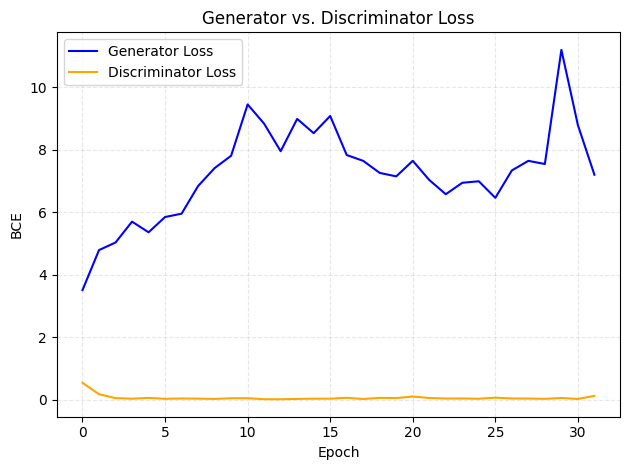

In [27]:
#plot learning curve
with torch.no_grad():
    plt.plot(train_loss_gen, color='blue', label='Generator Loss')
    plt.plot(train_loss_disc, color = 'orange', label = 'Discriminator Loss')
plt.legend()
plt.title('Generator vs. Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

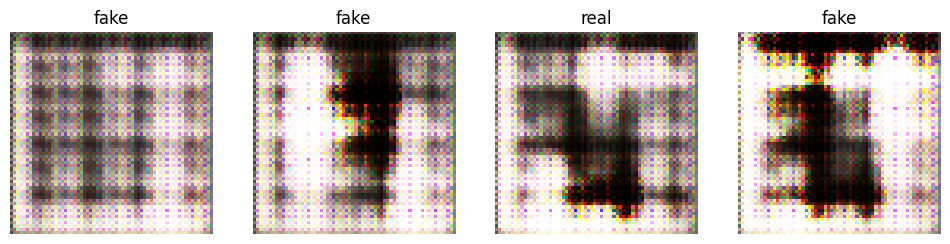

In [28]:
#plot instances with label of discriminator
with torch.no_grad():
    test_noise = torch.randn(4, 128, 1, 1)
    generated_images = gan_model(test_noise, mode='generator')

    discr_labels = gan_model(generated_images, mode ='discriminator')
    classified_labels = ["fake" if label < 0.5 else "real" for label in discr_labels]

    fig, axes = plt.subplots(1, 4, figsize=(12, 6)) 
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i].permute(1, 2, 0).numpy())  
        ax.set_title(classified_labels[i])
        ax.axis("off")

    plt.show()